In [53]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as mplt

In [3]:
# Read Phishing Email Transformed Data Set
phishing_dt = pd.read_csv('./Phishing_Email_Rich.csv')
target_column = phishing_dt.pop(phishing_dt.columns[2])
phishing_dt['Email Type'] = target_column
phishing_dt['URL Verification'] = phishing_dt['URL Verification'].fillna('No URL')
phishing_dt = phishing_dt.drop('Index', axis = 1)
phishing_dt = phishing_dt.drop('scores', axis = 1)
phishing_dt = phishing_dt.drop('TB_score', axis = 1)

label_encoder = LabelEncoder()
phishing_dt['URL Verification'] = label_encoder.fit_transform(phishing_dt['URL Verification'])
phishing_dt['Emotion'] = label_encoder.fit_transform(phishing_dt['Emotion'])
phishing_dt['Sentiment'] = label_encoder.fit_transform(phishing_dt['Sentiment'])
phishing_dt.head()

,Email Text,Lexical Errors,URL Verification,compound,Sentiment,TB_sentiment,Emotion,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",25.652174,0,0.9795,2,0.170139,7,Safe Email
1,the other side of * galicismos * * galicismo *...,28.571429,0,0.3612,2,0.009375,6,Safe Email
2,re : equistar deal tickets are you still avail...,20.000000,0,0.8591,2,0.091540,7,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,15.625000,1,0.9696,2,0.233333,7,Phishing Email
4,software at incredibly low prices ( 86 % lower...,42.857143,0,0.4767,2,0.152579,7,Phishing Email


In [4]:
from sklearn.model_selection import train_test_split
text_columns = ['Email Text']
numeric_columns = ['Lexical Errors', 'URL Verification', 'compound', 'Sentiment', 'TB_sentiment', 'Emotion']
x = phishing_dt.drop(columns=["Email Type"])
y = phishing_dt["Email Type"]

### Random Forest Classifier

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
# initialise model and vectorizers
model = RandomForestClassifier(n_estimators=10)
vectorizer = TfidfVectorizer(max_features=500)

In [59]:
tfidf_matrix = vectorizer.fit_transform(x["Email Text"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [64]:
x = phishing_dt.drop(columns=["Email Type"])
y = phishing_dt["Email Type"]
x_no_email = x.drop(columns=["Email Text"])
concatenated_df = pd.concat([tfidf_df,x_no_email ], axis=1, ignore_index=False)
x_full = concatenated_df
x_train, x_test, y_train, y_test = train_test_split(x_full, y, test_size=0.2, random_state=42)

In [65]:
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

In [66]:
y_pred = model.predict(x_test)

In [67]:
accuracy_score(y_test, y_pred)

0.9458563535911603

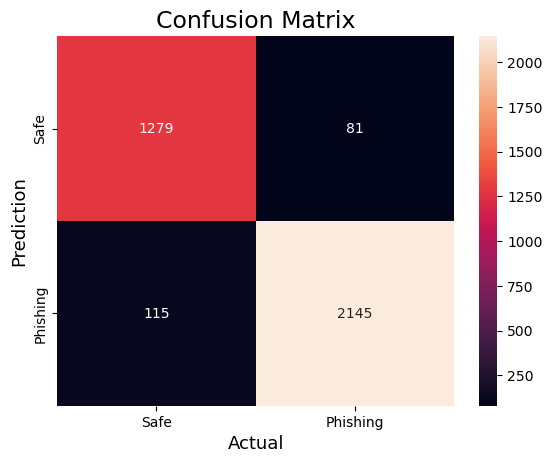

In [70]:
# Confusion Matrix for RF
phishing_confusion_matrix = confusion_matrix(y_test, y_pred)
sb.heatmap(
    phishing_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("Confusion Matrix", fontsize=17)
mplt.show()

### SVC Classifier

In [71]:
from sklearn.svm import SVC
model_svm= SVC(C = 100, gamma = "auto")

In [72]:
model_svm.fit(x_train,y_train)

SVC(C=100, gamma='auto')

In [73]:
s_ypred = model_svm.predict(x_test)
accuracy_score(y_test,s_ypred )

0.9577348066298342

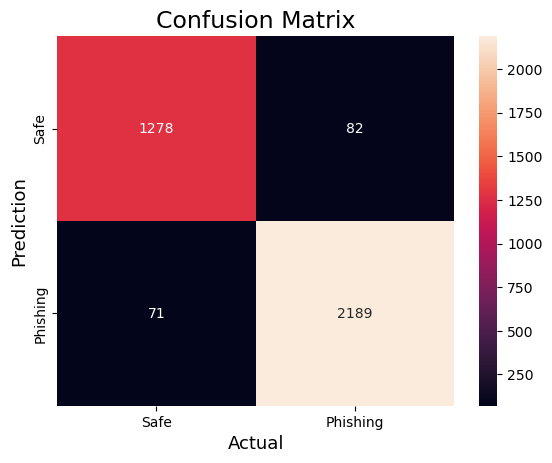

In [74]:
# Confusion Matrix for SVC
phishing_confusion_matrix = confusion_matrix(y_test, s_ypred)
sb.heatmap(
    phishing_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("Confusion Matrix", fontsize=17)
mplt.show()

### XGB Classifier

In [75]:
from sklearn.model_selection import KFold
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [76]:
from xgboost import XGBClassifier

In [77]:
def print_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

In [78]:
x_full_reset = x_full.reset_index(drop=True)
y_reset = y.reset_index(drop=True)

In [79]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'y' is your target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [80]:
fold = 1
n_estim = 100
for train_index, val_index in kfold.split(x_full_reset):
    X_train, X_val = x_full_reset.iloc[train_index], x_full_reset.iloc[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]
    model = XGBClassifier(n_estimators=n_estim, learning_rate=0.1, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42,enable_categorical=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print_report(y_val, y_pred, fold)
    fold += 1

Fold: 1
Accuracy Score: 0.9519337016574586
Confusion Matrix: 
 [[1272   88]
 [  86 2174]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1360
           1       0.96      0.96      0.96      2260

    accuracy                           0.95      3620
   macro avg       0.95      0.95      0.95      3620
weighted avg       0.95      0.95      0.95      3620

Fold: 2
Accuracy Score: 0.9541436464088398
Confusion Matrix: 
 [[1353   78]
 [  88 2101]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1431
           1       0.96      0.96      0.96      2189

    accuracy                           0.95      3620
   macro avg       0.95      0.95      0.95      3620
weighted avg       0.95      0.95      0.95      3620

Fold: 3
Accuracy Score: 0.9560773480662983
Confusion Matrix: 
 [[1341   58]
 [ 101 2120]]
Classification Report: 
  

### ANN

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [84]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

label_encoder = LabelEncoder()
y_test_int = label_encoder.fit_transform(y_test)

model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 10)
y_pred_prob = model.predict(x_test)
y_pred_ann = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test_int, y_pred_ann)
report = classification_report(y_test_int, y_pred_ann)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Epoch 1/10
453/453 [==============================] - 3s 2ms/step - loss: 0.6713 - accuracy: 0.6141
Epoch 2/10
453/453 [==============================] - 1s 2ms/step - loss: 0.6578 - accuracy: 0.6156
Epoch 3/10
453/453 [==============================] - 1s 3ms/step - loss: 0.6357 - accuracy: 0.6326
Epoch 4/10
453/453 [==============================] - 1s 3ms/step - loss: 0.5879 - accuracy: 0.6833
Epoch 5/10
453/453 [==============================] - 1s 3ms/step - loss: 0.4982 - accuracy: 0.7517
Epoch 6/10
453/453 [==============================] - 1s 2ms/step - loss: 0.3967 - accuracy: 0.8119
Epoch 7/10
453/453 [==============================] - 1s 2ms/step - loss: 0.3152 - accuracy: 0.8573
Epoch 8/10
453/453 [==============================] - 1s 2ms/step - loss: 0.2622 - accuracy: 0.8831
Epoch 9/10
453/453 [==============================] - 1s 2ms/step - loss: 0.2332 - accuracy: 0.8974
Epoch 10/10
114/114 [==============================] - 0s 1ms/step
Accuracy: 0.5082872928176796
Clas